In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
#criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
img = cv2.imread('test_images/test2.jpg')

images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img2 = cv2.imread(fname)
    gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print(ret)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

            # Draw and display the corners
        img2 = cv2.drawChessboardCorners(img2, (9,6), corners, ret)
# Read in an image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#print(objpoints)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [2]:
def undistorted_img(img, mtx, dist):
    
    undist =  cv2.undistort(img, mtx, dist, None, mtx)
    return undist

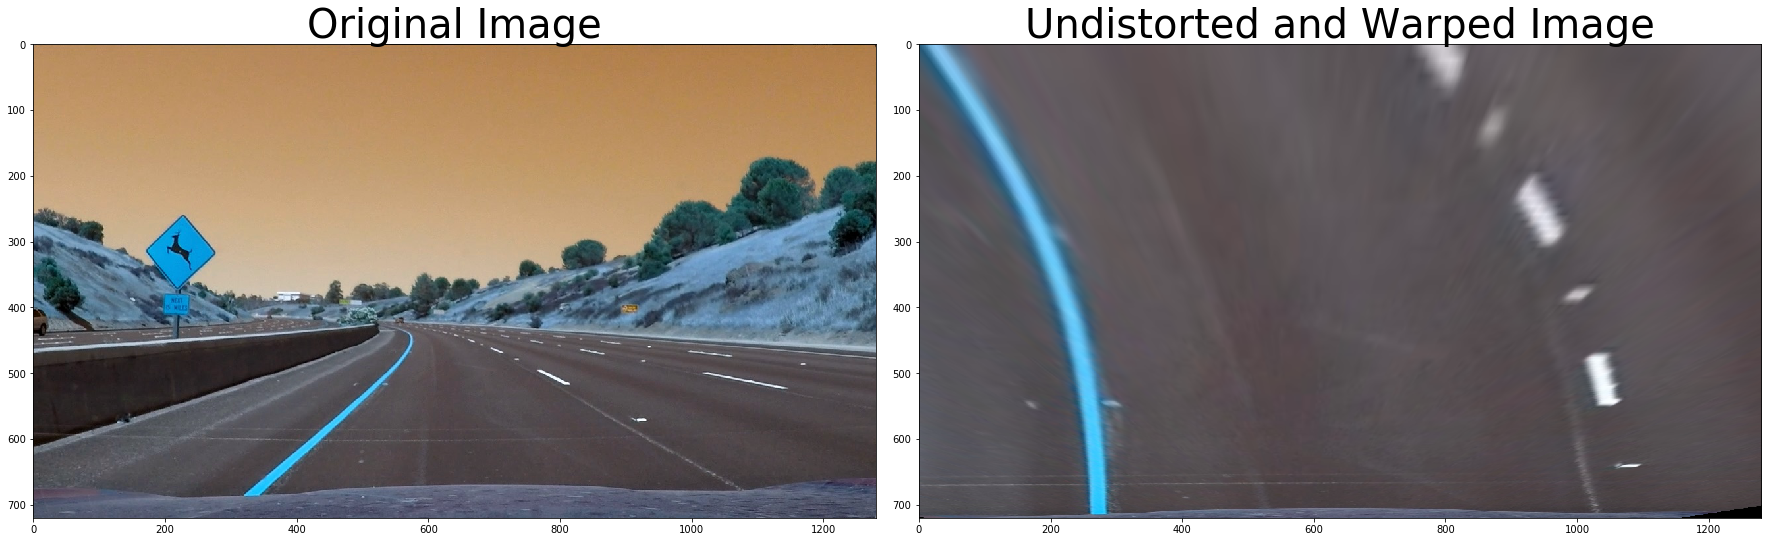

In [3]:
def warper(img):
    
    
    img_size = (img.shape[1], img.shape[0])
       
    src = np.float32([[210,img.shape[0]],[595,450],[690,450], [1110, img.shape[0]]])
    dst = np.float32([[200, img.shape[0]], [200, 0], [1000, 0], [1000, img.shape[0]]])

    M = cv2.getPerspectiveTransform(src, dst)
    inverse_M = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, inverse_M

undist = undistorted_img(img, mtx, dist)
img_size = (undist.shape[1], undist.shape[0])
wrap_img, perspective_M, inverse_M = warper(undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(wrap_img)
ax2.set_title('Undistorted and Warped Image', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)





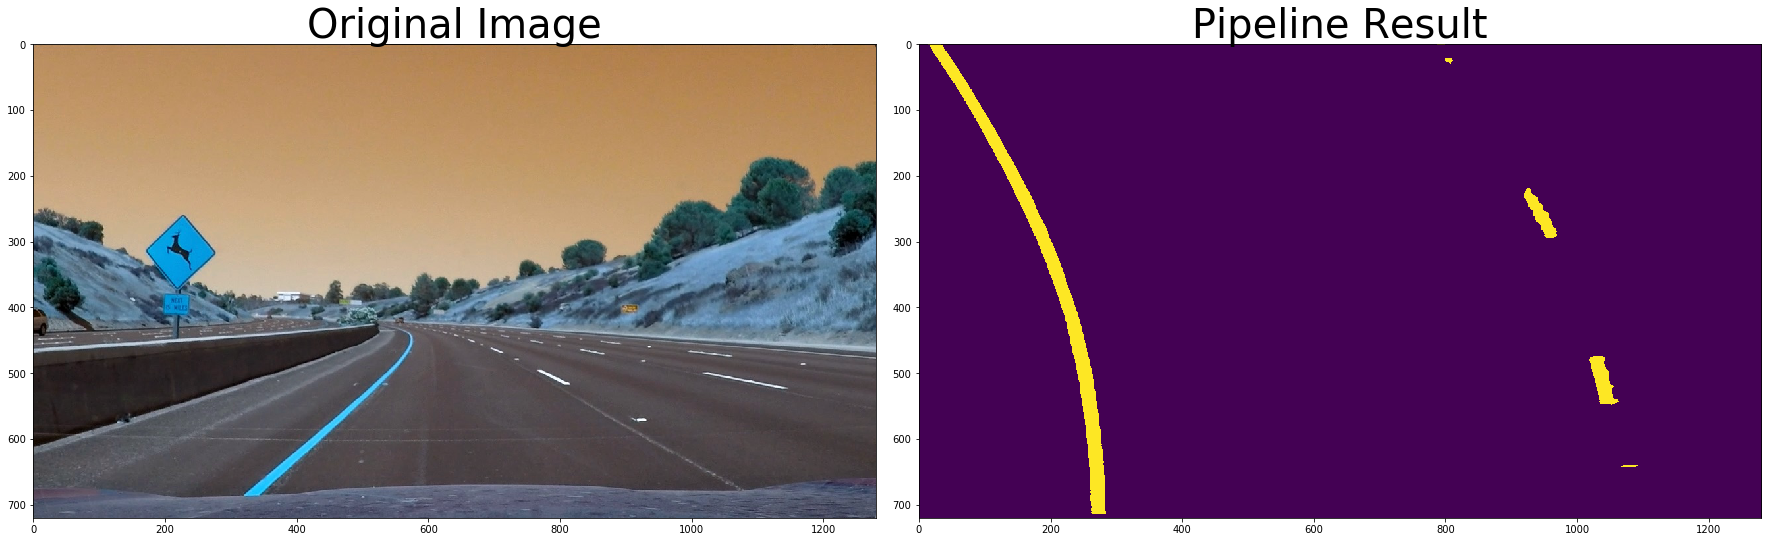

In [4]:
def pipeline(img):
    img = np.copy(img)
    mag_thresh=(120, 255)
    sx_thresh=(30, 250)
    sy_thresh=(20, 100)
    dir_thresh = (0.7, 1.1)
    v_thresh = (210, 255)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to HSV color space and separate the V channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #l_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    # Sobel x
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    mag_binary = np.zeros_like(grad_mag)
    mag_binary[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    # Threshold color channel
    
    # Stack each channel
    
    abs_grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= dir_thresh[0]) & (abs_grad_dir <= dir_thresh[1])] = 1
    
    combined_threshold = np.zeros_like(dir_binary)
    combined_threshold[((sxbinary == 1) & (sybinary == 1)) & (mag_binary == 1) ] = 1
    
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    #hls_binary = np.zeros_like(l_channel)
    #hls_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = np.dstack(( combined_threshold, combined_threshold, v_binary)) * 255
    combined_binary = np.zeros_like(gray)
    combined_binary[(v_binary == 1) | (combined_threshold == 1)] = 1
    return combined_binary
    
result = pipeline(wrap_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
def polyfit(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    nwindows=9
    margin=100
    minpix=50
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ym_per_pixel = 30/720 
    xm_per_pixel = 3.7/700 
    
    left_fit_m = np.polyfit(lefty*ym_per_pixel, leftx*xm_per_pixel, 2)
    right_fit_m = np.polyfit(righty*ym_per_pixel, rightx*xm_per_pixel, 2)
    radius, offset = get_radius_and_offset(left_fit_m, right_fit_m, ym_per_pixel, xm_per_pixel)

    
    return leftx, lefty, rightx, righty, radius, offset
    
    


In [6]:
def get_radius_and_offset(left_fit, right_fit, ym_per_pixel, xm_per_pixel):
    """Get the radius of a lane and the offset of the camera
    
    Given the the polynomial fit of two lines and the meters per pixel of an image, 
    calculate the mean radius of the curvature of the lane and the camera's distance 
    from the center of the lane.
    
    Parameters:
        left_fit (list): polynomial coefficients of the left lane, highest power first
        right_fit (list): polynomial coefficients of the right lane, highest power first
        ym_per_pixel (float):
        xm_per_pixel (float): 
        
    Returns:
        radius (float): median radius in meters of the left and right lane curvature 
        offset (float) : distance in meters from the center of the lane
    """
    left_curverad =  ((1 + (2*left_fit[0]*720*ym_per_pixel + left_fit[1])**2)**(3/2))/np.abs(2*left_fit[0])
    right_curverad =  ((1 + (2*right_fit[0]*720*ym_per_pixel + right_fit[1])**2)**(3/2))/np.abs(2*right_fit[0])
    
    left_lane = left_fit[0]*(720*ym_per_pixel)**2 + left_fit[1]*720*ym_per_pixel + left_fit[2]
    right_lane = right_fit[0]*(720*ym_per_pixel)**2 + right_fit[1]*720*ym_per_pixel + right_fit[2]
    
    radius = np.mean([left_curverad, right_curverad])
    offset = [640*xm_per_pixel - np.mean([left_lane, right_lane]), right_lane-left_lane]
    return radius, offset

def add_calculations(result_img, radius, offset):   
    """Add the radius and offset to an image
    
    Parameters:
        result_img (numpy.array): numpy array representation of an image 
        radius (float): median radius in meters of the left and right lane curvature 
        offset (float) : distance in meters from the center of the lane

    Returns:
        result_img (numpy.array): numpy array representation of an image with added text
    """
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    cv2.putText(result_img, 'Radius of Curvature: {} m'.format(round(radius)), (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)
    cv2.putText(result_img, 'Offset: {} m'.format(round(offset[0], 3)), (50, 200), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)
    
    return result_img

In [7]:
def drawing(undistorted_img, binary_warped, inverse_M, leftx, lefty, rightx, righty, img_size): 
    

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
       
    
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, inverse_M, img_size) 

    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

    
    return result, left_fit, right_fit

In [8]:
class Line(object):
    def __init__(self):
        self.left_fit = None
        self.right_fit = None 
        

In [9]:
def process_image(image, line):
    
    img_size = (image.shape[1], image.shape[0])

    
    undist = undistorted_img(image, mtx, dist)
    
    warp_img, perspective_M, inverse_M = warper(undist)
    result = pipeline(warp_img)
    

    leftx, lefty, rightx, righty, radius, offset = polyfit(result)
    result, left_fit, right_fit = drawing(undist, result, inverse_M, leftx, lefty, rightx, righty, img_size)
    result = add_calculations(result, radius, offset)
    line.left_fit = left_fit
    line.right_fit = right_fit
    
    return result

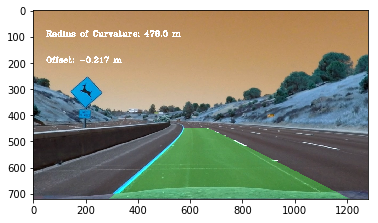

In [10]:
leftx, lefty, rightx, righty, radius, offset = polyfit(result)
result, left_fit, right_fit = drawing(undist, result, inverse_M, leftx, lefty, rightx, righty, img_size)
result = add_calculations(result, radius, offset)
plt.imshow(result)

In [11]:
line = Line()
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(lambda x: process_image(x, line))

In [12]:
white_output = 'test_videos_output/project_video.mp4'
%time video_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [06:18<00:00,  3.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 3min 27s, sys: 41.9 s, total: 4min 9s
Wall time: 6min 21s


In [13]:
from IPython.display import HTML

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))